In [ ]:
!nvidia-smi

Thu Jun 25 19:00:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 675kB 8.4MB/s 
     |████████████████████████████████| 3.8MB 24.7MB/s 
     |████████████████████████████████| 890kB 46.1MB/s 
     |████████████████████████████████| 1.1MB 53.9MB/s 


In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 50.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 27.1MB/s]


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

In [ ]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape

(15746, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Text(0.5, 0, 'Review Scores')

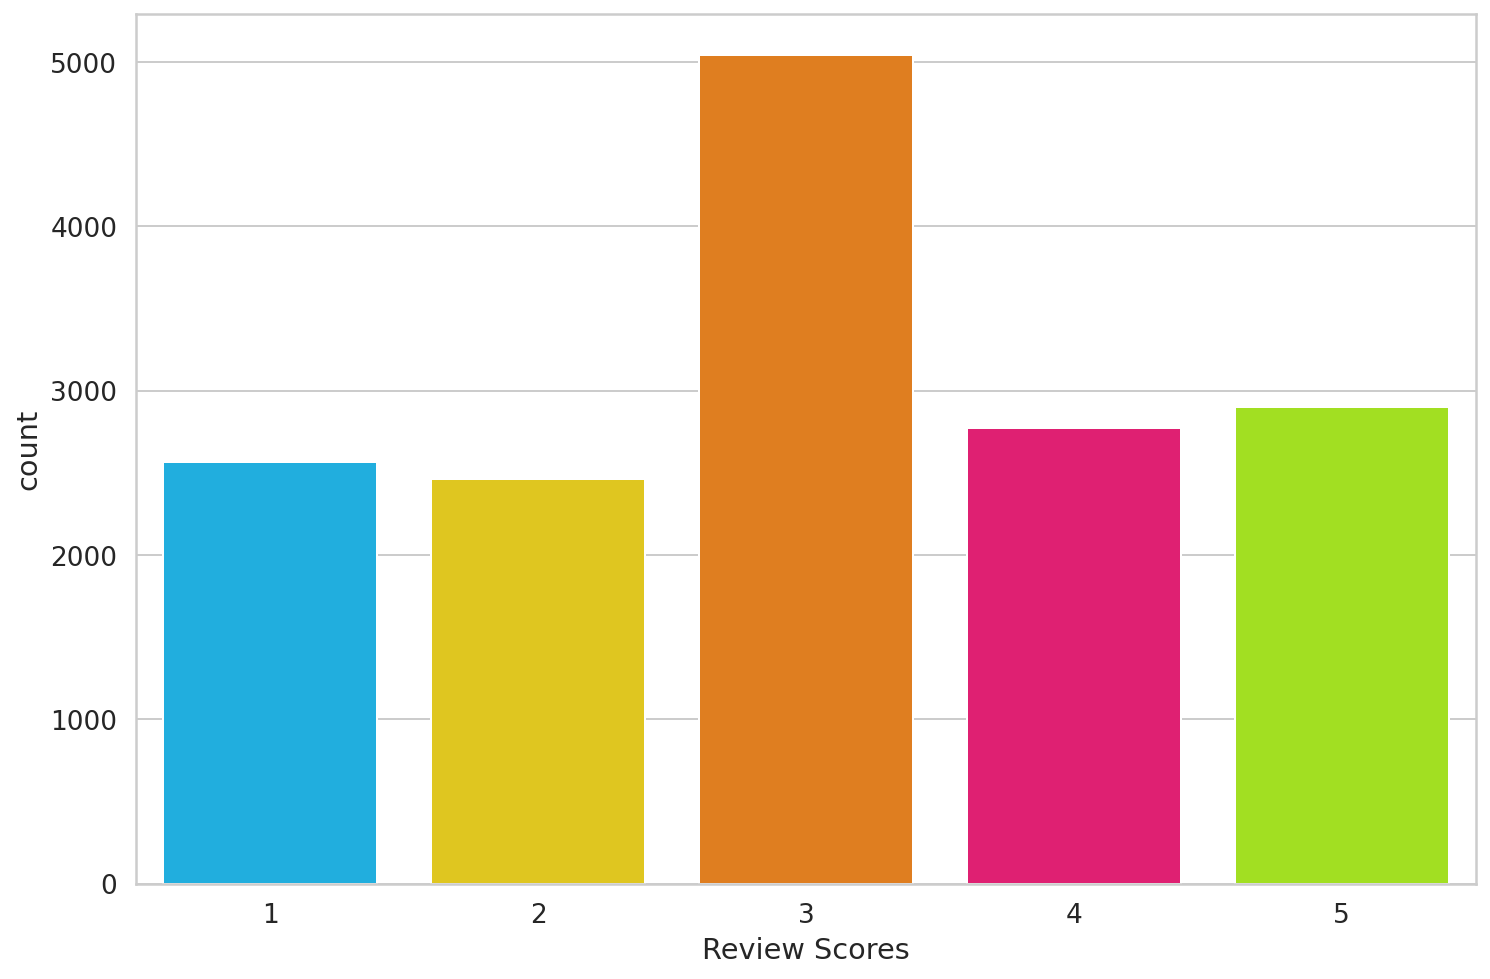

In [ ]:
sns.countplot(df.score)
plt.xlabel('Review Scores')

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative','neutral','positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

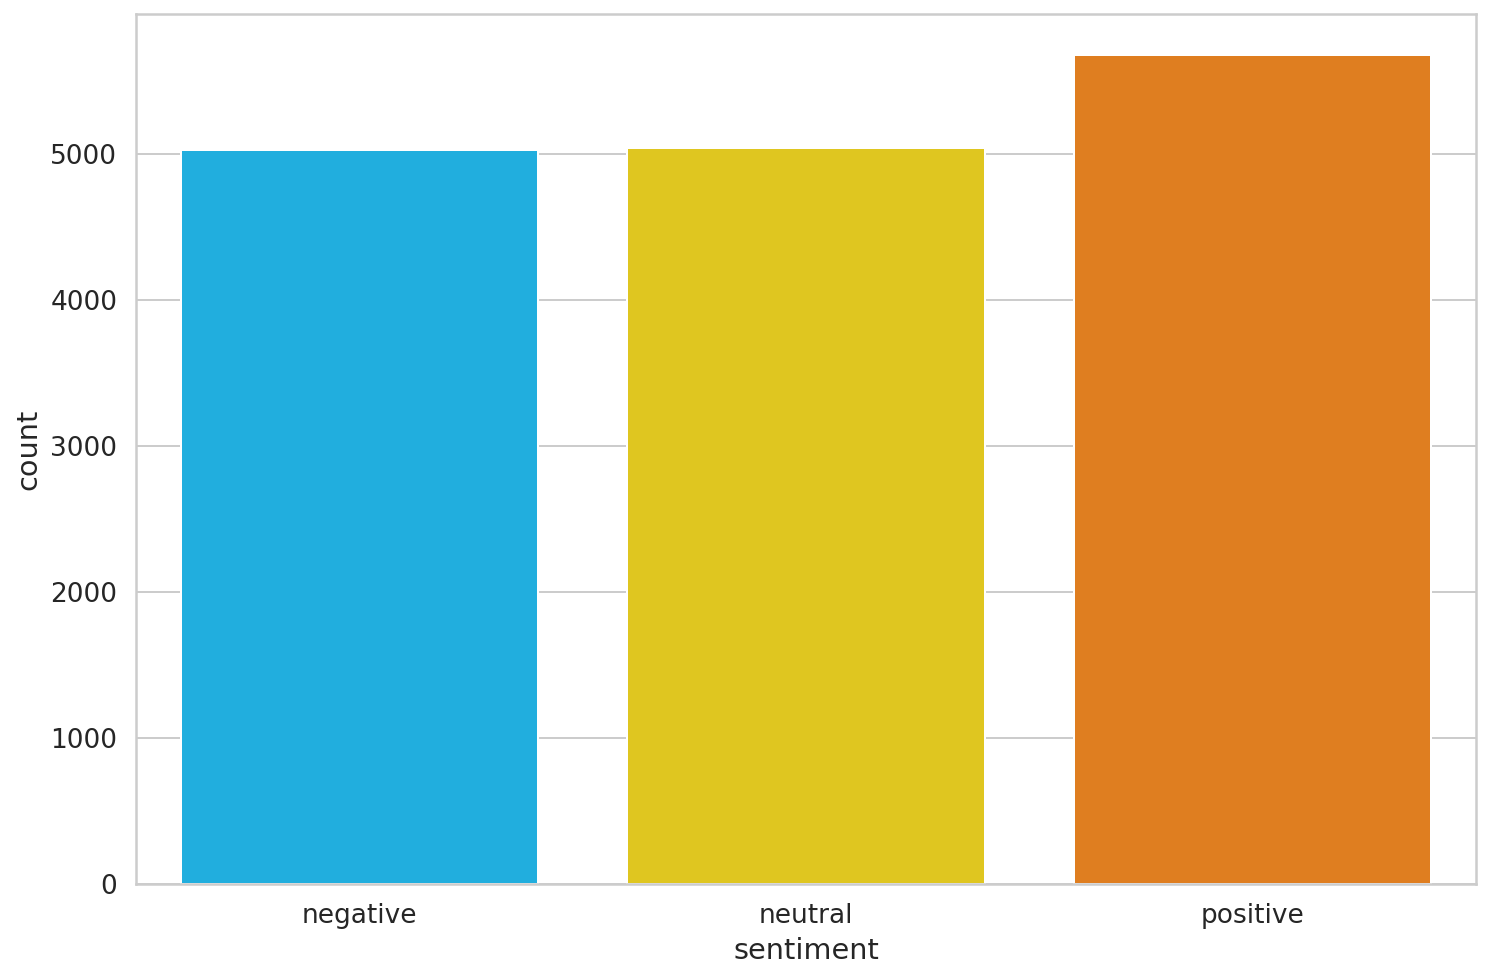

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel = ('Setiments Classes')
ax.set_xticklabels(class_names)

## Data Preprocessing

1. Add special tokens to separate sentences and do classification
2. Pass sequences of constant length (introduce padding)
3. Create array of 0s (pad token) and 1s (real token) called attention mask

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'We shall figure out a way to get rid of the pandemic situation!.It is quite disgusting right?'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: We shall figure out a way to get rid of the pandemic situation!.It is quite disgusting right?
   Tokens: ['We', 'shall', 'figure', 'out', 'a', 'way', 'to', 'get', 'rid', 'of', 'the', 'pan', '##de', '##mic', 'situation', '!', '.', 'It', 'is', 'quite', 'disgusting', 'right', '?']
Token IDs: [1284, 4103, 2482, 1149, 170, 1236, 1106, 1243, 9297, 1104, 1103, 13316, 2007, 7257, 2820, 106, 119, 1135, 1110, 2385, 22852, 1268, 136]


## Special Tokens

1. [SEP] - marker for eding of a sentence.
2. [CLS] - We add this token to the start of the sentence.
3. [PAD] - Padding Token.
4. [UNK] -  Unknown Token.

In [ ]:
print(tokenizer.sep_token,tokenizer.sep_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)

[SEP] 102
[CLS] 101
[CLS] 101


In [ ]:
tokenizer.unk_token,tokenizer.unk_token_id # Unknown Token ID

('[UNK]', 100)

## Encoding the given sentence with appropiate tokens.

Returns a dictionary containing the encoded sequence or sequence pair and additional information: the mask for sequence classification and the overflowing elements if a max_length is specified.

In a nutshell, the overall process of performing tokenisation and attention mask is done in the encoding_plus function.

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding

{'input_ids': tensor([[  101,  1284,  4103,  2482,  1149,   170,  1236,  1106,  1243,  9297,
          1104,  1103, 13316,  2007,  7257,  2820,   106,   119,  1135,  1110,
          2385, 22852,  1268,   136,   102,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1284,  4103,  2482,  1149,   170,  1236,  1106,  1243,  9297,
         1104,  1103, 13316,  2007,  7257,  2820,   106,   119,  1135,  1110,
         2385, 22852,  1268,   136,   102,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'] # If the token is a embedding_token the it returns 1 else 0

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])

## Take a look at the tokens generated

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'We',
 'shall',
 'figure',
 'out',
 'a',
 'way',
 'to',
 'get',
 'rid',
 'of',
 'the',
 'pan',
 '##de',
 '##mic',
 'situation',
 '!',
 '.',
 'It',
 'is',
 'quite',
 'disgusting',
 'right',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# Choosing a Fixed Length

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

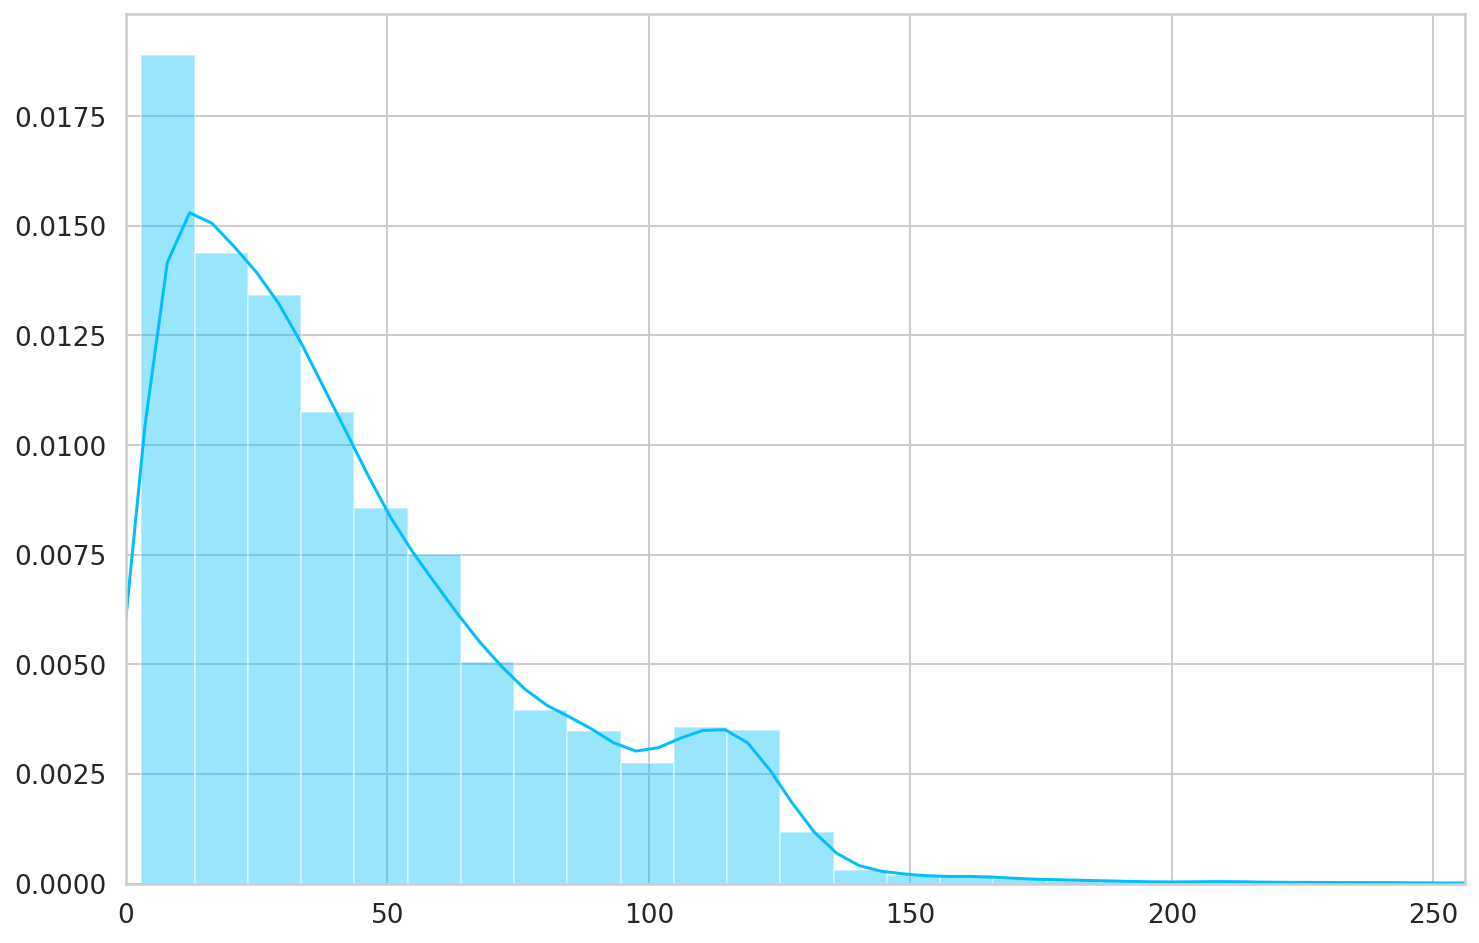

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);

In [ ]:
MAX_LEN = 160

## Creating a Pytorch Dataset

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

# Split the data into train and test

In [ ]:
df_train,df_test = train_test_split(
    df,
    test_size=0.1,
    random_state= RANDOM_SEED
)

In [ ]:
df_val,df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [ ]:
df_train.shape,df_test.shape,df_val.shape

((14171, 12), (788, 12), (787, 12))

## Create DataLoaders

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Sentiment Classification

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state,pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape # 1 example and 768 hidden_units

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape # Performs pooling operation by applying Tanh function 

torch.Size([1, 768])

In [ ]:
bert_model.config.hidden_size

768

## Sentiment Classifier

In [ ]:
class  SentimentClassifer(nn.Module):
  def __init__(self,n_classes):
    super(SentimentClassifer,self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size,n_classes)
    self.softmax = nn.Softmax(dim=1)


  def forward(self,input_ids,attention_mask):
    _,pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [ ]:
model = SentimentClassifer(len(class_names))
model = model.to(device)

In [ ]:
!nvidia-smi

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [53]:
model(input_ids,attention_mask) # Sample predictions

tensor([[0.3811, 0.1191, 0.4998],
        [0.5207, 0.1852, 0.2941],
        [0.5458, 0.1383, 0.3158],
        [0.5361, 0.1461, 0.3178],
        [0.4148, 0.1836, 0.4016],
        [0.4153, 0.1150, 0.4697],
        [0.3680, 0.1162, 0.5158],
        [0.5784, 0.1504, 0.2712],
        [0.4495, 0.1179, 0.4326],
        [0.3391, 0.1083, 0.5526],
        [0.3842, 0.0657, 0.5502],
        [0.2729, 0.2213, 0.5058],
        [0.4266, 0.0780, 0.4954],
        [0.4010, 0.1377, 0.4613],
        [0.3526, 0.2346, 0.4128],
        [0.4092, 0.0947, 0.4961]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training

In [59]:
EPOCHS =10

optimizer = AdamW(model.parameters(),lr=2e-5,correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps= total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [55]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [57]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'EPOCH {epoch+1}/{EPOCHS}')
  print('-'*10)

  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train Loss {train_loss} accuracy {train_acc}')

  val_acc,val_loss = train_epoch(
      model,
      val_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_val)
  )

  print(f'Validation Loss {train_loss} Validation_accuracy {train_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_acc)

  history['val_acc'].append(train_acc)
  history['val_loss'].append(train_acc)

  if val_acc > best_accuracy:
    torch.save(model.state_dict,'model.pth')
    best_accuracy = val_acc